# Autoencoding our variables

This version includes the Eukaryotes in the data. We don't want it for a lot of things, but some ... eg. to check Aspergillus ... we need it.

The Data Frame has shape: (127, 2626)

### Import the python torch and tensorflow modules and make sure we're ready to rock and roll

In [1]:
import os
import sys
import torch

import tensorflow as tf
from tensorflow.keras import layers, models

if not torch.cuda.is_available():
    print("FATAL: Please run this notebook in an environment with CUDA available", file=sys.stderr)
else:
    print("Lets go GPU", file=sys.stderr)

2025-02-02 13:36:56.704509: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Lets go GPU


## Import the libraries.

This is my standard import.

In [2]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import json
import random

from itertools import cycle
from collections import Counter

import networkx as nx
import community

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor, ClassifierChain
from sklearn.metrics import mean_squared_error

from scipy.stats import linregress
from scipy.cluster.hierarchy import linkage, fcluster

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor


# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

try:
  import google.colab
  IN_COLAB = True
  !pip install adjustText
  from google.colab import drive
  drive.mount('/content/drive')
  datadir = '/content/drive/MyDrive/Projects/CF/Adelaide/CF_Data_Analysis'
except ImportError:
  IN_COLAB = False
  datadir = '..'


from socket import gethostname
hostname = gethostname()
if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False

import cf_analysis_lib


from adjustText import adjust_text

## Read the data

In [3]:
sequence_type = "MGI"
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel=sslevel, taxa=taxa, all_taxa=True, verbose=True)

print(f"The Data Frame has shape: {df.shape}")

Read 127 samples and 769 subsystems
Read 127 samples and 1857 family
Read 127 samples and 166 metadata columns


## Somewhere to save the outputs!

In [4]:
outdir = 'cluster_gbrfs_eukaryotes'
os.makedirs(outdir, exist_ok=True)

### Split the data

In [5]:
training_data, validate_data = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train: {training_data.shape}")
print(f"Test: {validate_data.shape}")

Train: (101, 2626)
Test: (26, 2626)


## Develop the autoencoder

Because an autoencoder reconstructs its inputs, the “labels” (y) are the same as the features (X), so `x=training_data`, and `y=training_data`.

In [23]:
# do we have a saved model?

if os.path.exists(os.path.join(outdir, "autoencoder_model")):
    print(f"Loading the autoencoder from disk. Remove {os.path.join(outdir, 'autoencoder_model')} to recreate the model", file=sys.stderr)
    autoencoder = models.load_model(os.path.join(outdir, "autoencoder_model"), compile=False)
    autoencoder.compile(optimizer='adam', loss='mse')
    encoder = models.load_model(os.path.join(outdir, "encoder_model"), compile=False)
    decoder = models.load_model(os.path.join(outdir, "decoder_model"), compile=False)
    encoder.compile()
    decoder.compile()
else:
    # 1) Define network parameters
    input_dim = len(df.columns)
    latent_dim = 100  # tweak this
    
    # 2) Build the encoder
    encoder_input = tf.keras.Input(shape=(input_dim,))
    x = layers.Dense(1024, activation='relu')(encoder_input)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    encoder_output = layers.Dense(latent_dim, activation='linear')(x)
    
    # 3) Build the decoder
    decoder_input = layers.Input(shape=(latent_dim,))
    y = layers.Dense(128, activation='relu')(decoder_input)
    y = layers.Dense(512, activation='relu')(y)
    y = layers.Dense(1024, activation='relu')(y)
    decoder_output = layers.Dense(input_dim, activation='linear')(y)
    
    # 4) Create autoencoder
    encoder = tf.keras.Model(encoder_input, encoder_output, name="encoder")
    decoder = tf.keras.Model(decoder_input, decoder_output, name="decoder")
    
    autoencoder_input = tf.keras.Input(shape=(input_dim,))
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded)
    
    autoencoder = tf.keras.Model(autoencoder_input, decoded, name="autoencoder")
    
    # 5) Compile & train
    autoencoder.compile(optimizer='adam', loss='mse')
    result = autoencoder.fit(
        x=training_data,
        y=training_data,
        epochs=200,
        batch_size=16,
        validation_data=(validate_data, validate_data),
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)]
    )


    autoencoder.save(os.path.join(outdir, "autoencoder_model"), overwrite=True)
    encoder.save(os.path.join(outdir, "encoder_model"), overwrite=True)
    decoder.save(os.path.join(outdir, "decoder_model"), overwrite=True)

    # Plot training & validation loss
    plt.plot(result.history['loss'], label='Training Loss')
    plt.plot(result.history['val_loss'], label='Validation Loss')
    
    plt.title('Autoencoder Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
# 6) Extract low-dimensional features
train_latent = encoder.predict(training_data)
val_latent = encoder.predict(validate_data)
all_data = encoder.predict(df)

Loading the autoencoder from disk. Remove cluster_gbrfs_eukaryotes/autoencoder_model to recreate the model


4/4 [==============================] - 0s 2ms/step


# Predict which original features cluster

Looking at the correlation to the encoded data

We compute Correlation Between Each Original Feature and Each Latent Dimension

In [7]:
num_features = df.shape[1]  # 1512
num_latent_dims = all_data.shape[1]       # 50 - the number of output layers

corr_matrix = pd.DataFrame(index=df.columns, columns=[f"LD_{i}" for i in range(num_latent_dims)])

for i in range(num_features):
    for j in range(num_latent_dims):
        try:
            corr = np.corrcoef(df.iloc[:, i], all_data[:, j])[0, 1]
            corr_matrix.iloc[i, j] = corr
        except:
            print(f"Error predicting {i} and {j}", file=sys.stderr)
            break

corr_matrix = corr_matrix.astype(float)
corr_matrix.head()

,LD_0,LD_1,LD_2,LD_3,LD_4,LD_5,LD_6,LD_7,LD_8,LD_9,...,LD_90,LD_91,LD_92,LD_93,LD_94,LD_95,LD_96,LD_97,LD_98,LD_99
"2,3-diacetamido-2,3-dideoxy-d-mannuronic acid",0.186330,-0.049182,0.182427,0.175022,0.255017,-0.217577,-0.144753,0.041631,-0.023329,-0.136573,...,0.109363,-0.289665,0.018677,0.057040,0.179225,0.219395,0.182535,-0.119195,0.168439,-0.042183
2-O-alpha-mannosyl-D-glycerate utilization,-0.655631,0.054354,-0.172247,-0.538427,-0.337614,0.366825,0.203458,-0.373780,-0.025919,0.472061,...,0.174082,0.571328,0.153241,0.043208,-0.090944,-0.638426,-0.322575,0.228343,-0.357598,-0.274215
2-aminophenol Metabolism,-0.016861,-0.305825,0.217921,-0.055119,0.110072,-0.111195,0.008098,-0.163174,-0.115460,0.174926,...,0.377952,-0.033610,0.317214,0.257731,0.228879,0.002466,0.049277,0.024321,0.186560,-0.242783
2-ketoacid oxidoreductases disambiguation,0.305482,-0.247300,0.124878,0.271499,0.031340,-0.491902,-0.014317,-0.057207,-0.020191,-0.390436,...,0.054409,-0.598524,-0.139826,0.076035,0.357564,0.177510,0.068252,-0.108550,0.668116,0.138532
2-oxoglutarate dehydrogenase,0.436916,-0.479289,0.072585,0.270526,0.191057,-0.258265,0.129644,0.138092,-0.139811,-0.005397,...,0.036610,-0.211876,-0.028764,0.001632,0.173890,0.322195,0.230629,-0.097116,0.328334,-0.029463


## Cluster the original input data and the latent models using k-means

Here, we take the correlation matrix from the ANN - correlating which of our 1512 features map to the same output nodes from the ANN and we build clusters using k-means hierarchical clustering.

The 150 clusters is somewhat random - it is ~10% of the input data and it only gives 3 singletons, and breaks the Pseudomonas cluster down quite a bit.

In [8]:
if os.path.exists(os.path.join(outdir, 'clusters.json')):
    with open(os.path.join(outdir, 'clusters.json'), 'r') as file:
        data = json.load(file)
    tmpjsondf = pd.DataFrame(list(data.items()), columns=['Cluster', 'Feature'])
    cluster_assignments = tmpjsondf.explode('Feature').reset_index(drop=True)
    cluster_assignments['Cluster'] = cluster_assignments['Cluster'].astype(int)
else:
    # Calculate linkage on the rows (i.e., the features)
    Z = linkage(corr_matrix, method='ward', metric='euclidean')
    
    k = 300  # more clusters, smaller groups!
    clusters = fcluster(Z, k, criterion='maxclust')  # Each feature gets a cluster ID [1..k]
    
    # create a df with the cluster assignments
    cluster_assignments = pd.DataFrame({
        "Feature": corr_matrix.index,  # the feature names
        "Cluster": clusters
    })
    cluster_assignments.sort_values("Cluster", inplace=True)
    grouped = cluster_assignments.groupby("Cluster")
    by_cluster = {str(cluster_id): group["Feature"].tolist() for cluster_id, group in grouped}
    with open(os.path.join(outdir, 'clusters.json'), 'w') as json_file:
        json.dump(by_cluster, json_file, indent=4)


### Print out the clusters that contain _Pseudomonas_ subsystems

In [9]:
interesting_cluster = None
interesting_cluster_count = 0
grouped = cluster_assignments.groupby("Cluster")
for cluster_id, group in grouped:
    if group['Feature'].str.contains('Pseudomonas').any():
        if group['Feature'].str.contains('Pseudomonas').sum() > interesting_cluster_count:
            interesting_cluster_count = group['Feature'].str.contains('Pseudomonas').sum()
            interesting_cluster = cluster_id
        print(f"--- Cluster {cluster_id} : Length {group['Feature'].shape[0]} ---")
        print(group["Feature"].tolist())
        print()

--- Cluster 56 : Length 44 ---
['Colwelliaceae', 'Trans-envelope signaling system VreARI in Pseudomonas', 'Heme and heme d1 biosynthesis from siroheme', 'Type III secretion system orphans', 'L-2-amino-4-methoxy-trans-3-butenoic acid synthesis', 'Type III secretion systems', 'Potential DNA repair cluster', 'Extracellular matrix proteins (PSL) involved in mannose-rich biofilm formation in Pseudomonas', 'Salmochelin-mediated Iron Acquisition', 'Onchocercidae', 'Extracellular matrix proteins (PEL) involved in glucose-rich biofilm formation in Pseudomonas', 'ABC-type iron transport system', 'Pseudomonadaceae', 'IbrA and IbrB: co-activators of prophage gene expression', 'Siderophore Pyoverdine', 'Edwardsiidae', 'Acyclic terpene utilization', 'Aestuariirhabdaceae', 'Adenylylsulfate reductase', 'Capitellidae', 'Marinobacteraceae', 'Geothermobacteraceae', 'Lipotidae', 'Type III secretion system', 'Cholera toxin', 'MexXY System of Pseudomonas aeruginosa', 'Beta-lactamases Ambler class D', 'Mycob

### How many singletons are there in the groups?

In [10]:
singletons = 0
for cluster_id, group in grouped:
    if group['Feature'].shape[0] == 1:
        singletons+=1
print(f"There are {singletons} single clusters")

There are 36 single clusters


## Write all the clusters out

This is so we can use them again!

In [11]:
grouped = cluster_assignments.groupby("Cluster")
with open(os.path.join(outdir, 'cluster_features.txt'), 'w') as out:
    for cluster_id, group in grouped:
        print(f"--- Cluster {cluster_id} : Length {group['Feature'].shape[0]} ---", file=out)
        print(group["Feature"].tolist(), file=out)
        print(file=out)
cluster_assignments.to_csv(os.path.join(outdir, 'clusters.tsv'), sep="\t", index=False)

In [12]:
intcols = ['Pseudomonas Culture', 'N12M_Pseudomonas aeruginosa', 'N12M_mucoid', 'N12M_non_mucoid']
df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == interesting_cluster, "Feature"]]
merged_df_clust = df_clust.join(metadata[intcols])
merged_df_clust.to_csv(os.path.join(outdir, 'Pseudomonas_cluster.tsv'), sep="\t")

### Cluster correlations

Now we have clusters, lets take one cluster and see how it correlates to itself.

Note that the ANN has learnt things that both positively and negatively correlate.

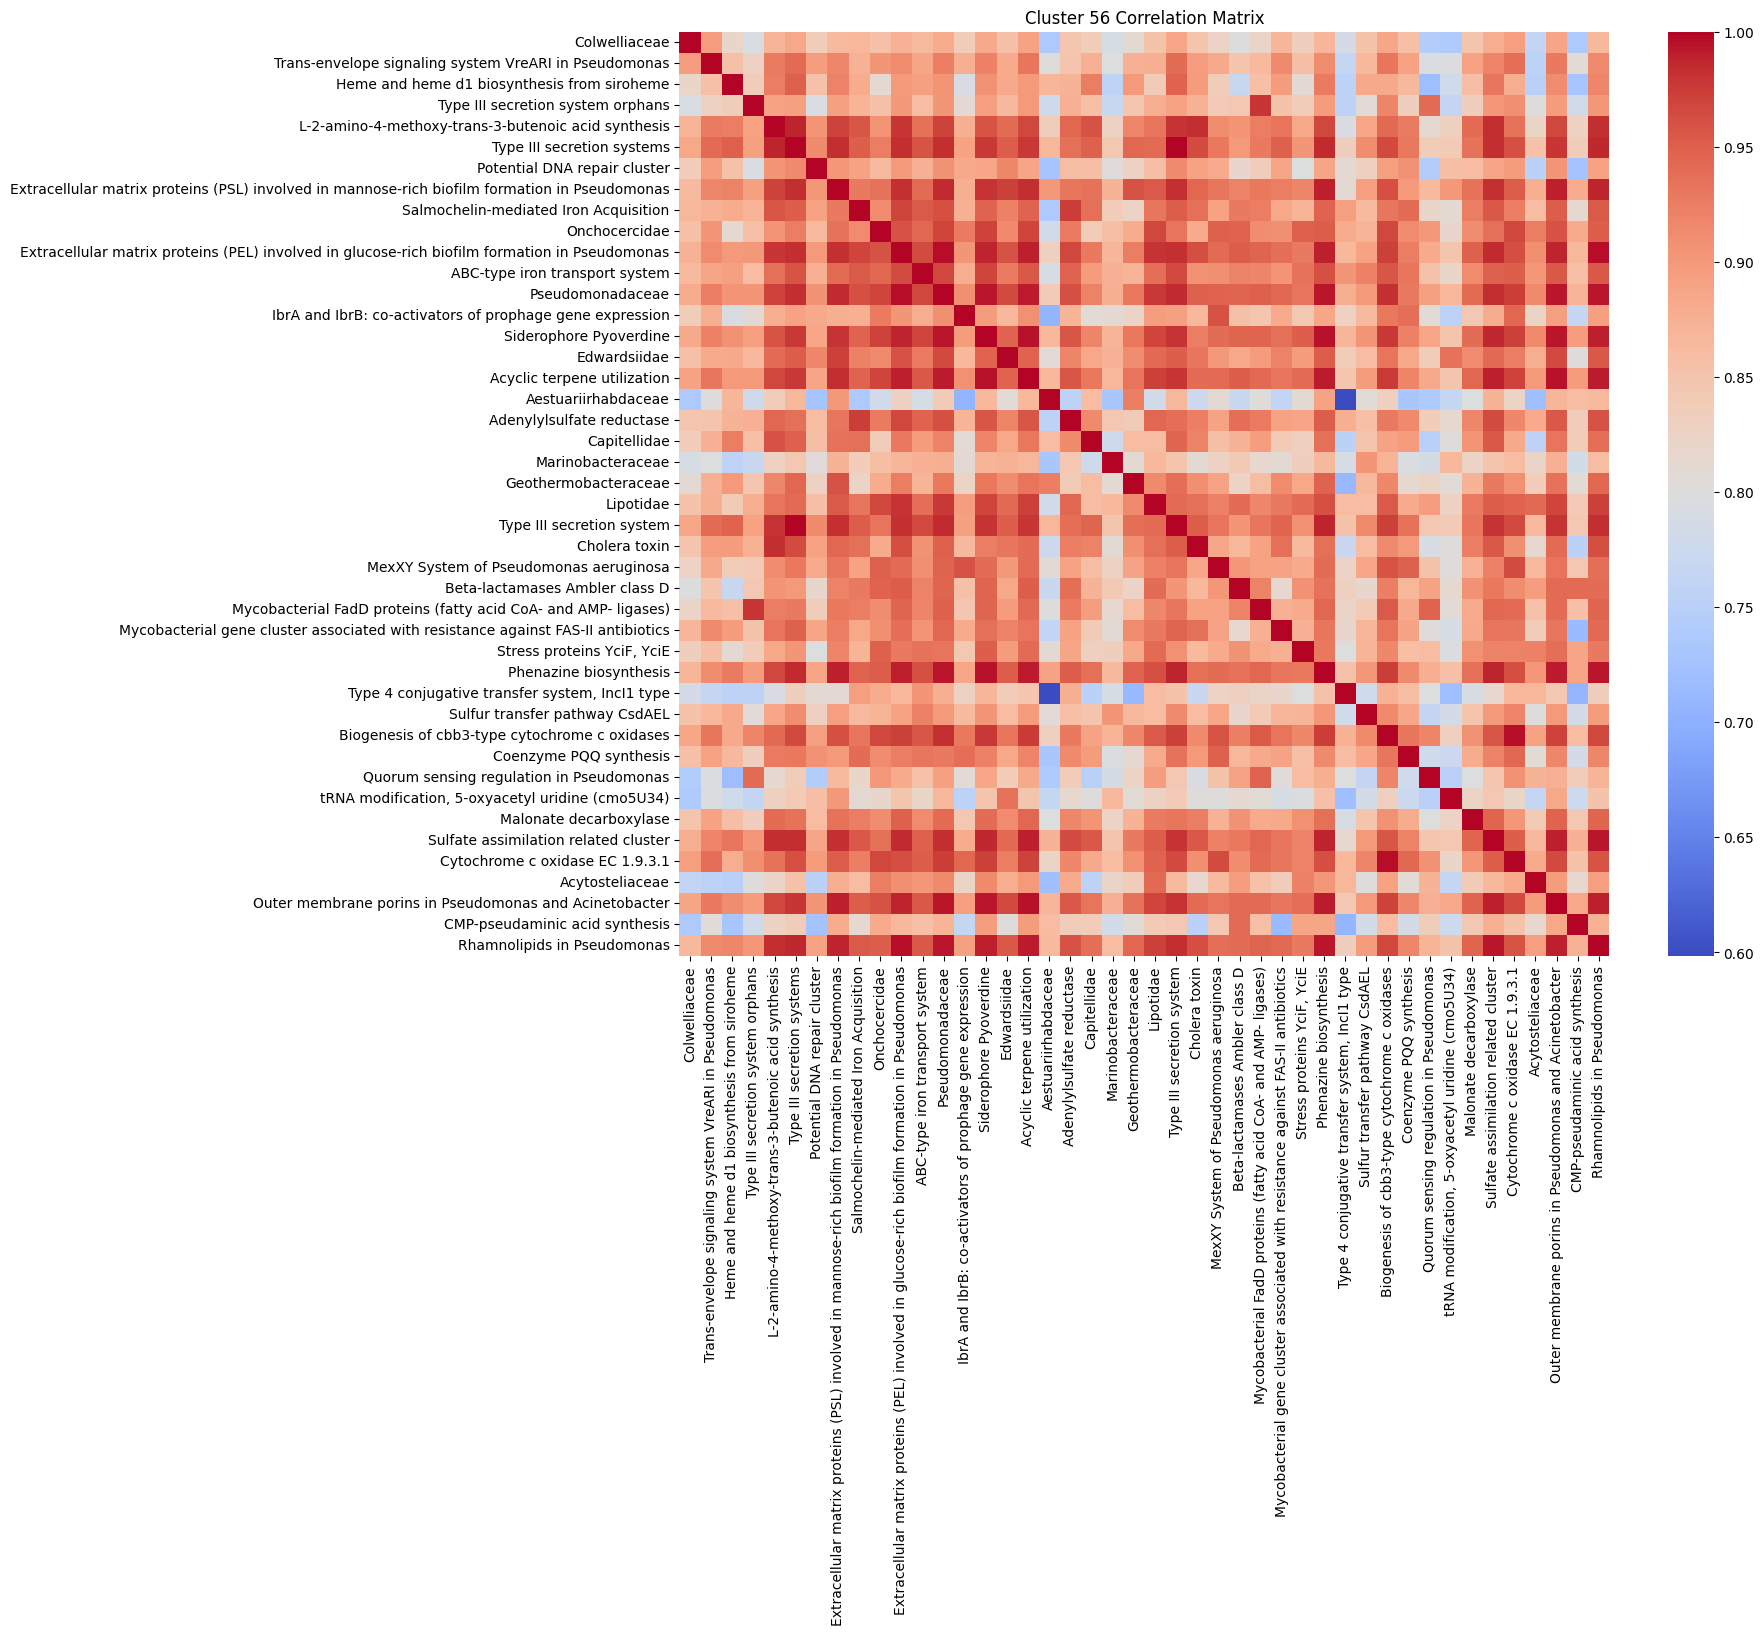

In [13]:
df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == interesting_cluster, "Feature"]]
df_clust_corr = df_clust.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(df_clust_corr, annot=False, cmap='coolwarm')
plt.title(f'Cluster {interesting_cluster} Correlation Matrix')
plt.show()

## Creating a new df with principal components of the data

Here, we make a new data frame that has the PC1 for each _cluster_. This doesn't matter if the cluster has positive/negative correlations because we are looking at the PC.

We can use this matrix in our machine learning approaches like gradient boosted random forest!

In [14]:
if os.path.exists(os.path.join(outdir, 'pc_df.tsv')):
    pc_df = pd.read_csv(os.path.join(outdir, 'pc_df.tsv'), sep="\t", index_col=0)
else:
    pca = PCA(n_components=1)
    pc_df = pd.DataFrame(index=df.index, columns=[f"Cluster {x+1}" for x in range(len(cluster_assignments.groupby("Cluster").size()))])
    for cluster_id, group in grouped:
        df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == cluster_id, "Feature"]]
        pc_df[f"Cluster {cluster_id}"] = pca.fit_transform(df_clust).ravel()
    pc_df.to_csv(os.path.join(outdir, 'pc_df.tsv'), sep="\t")
pc_df

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,...,Cluster 291,Cluster 292,Cluster 293,Cluster 294,Cluster 295,Cluster 296,Cluster 297,Cluster 298,Cluster 299,Cluster 300
1068841_20180306_S,1333.616082,93.523795,417.306380,1589.563344,434.631304,94.348096,809.550066,463.018643,144.850609,1742.761581,...,-13921.151625,-2.837355,-3436.738241,-182.618980,-31.351340,-6.462112,-149.055516,-197.292442,9295.052376,-371.213050
1447437_20171212_S,1428.796197,499.861256,4407.075901,3513.432275,344.083732,2240.022065,914.797213,944.196191,-916.437572,-3086.325157,...,-58.178099,-1.280985,-3973.108329,112.648468,20.317646,4.391036,-51.703938,2.616427,2956.281604,-1137.130643
1128691_20171206_S,-3966.477322,82.162090,-2949.776064,-6682.429189,-948.556639,-3913.995159,-1993.036047,-2961.794206,-469.903486,-7510.704278,...,-16647.058086,-2.300057,-3633.201217,-73.234015,-431.291585,-7.061739,-230.327521,630.041378,-4015.938484,-1565.731419
1128691_20171218_S,-3388.833001,-103.312371,-1863.133128,-5465.314395,-429.086775,-2826.259082,-1392.335084,-2489.150875,-548.301211,-6618.096262,...,-16258.668636,-5.319685,-5122.770322,27.242795,-250.820492,4.219732,-345.132177,545.224269,-4114.978204,-1512.643368
1128691_20180116_S,-4530.847672,-135.146481,-3368.220807,-7277.099967,-938.800482,-4110.860473,-2202.300602,-3165.542126,-537.496053,-7649.269676,...,-16970.275001,-5.319685,-4705.854834,10.553703,-397.900932,-7.061739,-374.437662,925.252589,-4328.336568,-1463.853044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895293_20180502_S,-668.773653,-63.729206,-392.006754,2898.763020,128.327351,1778.888293,-996.609350,-959.497283,147.641680,-1037.275948,...,-17380.936692,-2.308456,-3461.918267,-484.356873,336.712753,-0.847975,267.514959,654.239033,2991.351047,92.000959
896213_20180427_S,-982.022756,-232.708718,-996.135839,433.161953,-446.440054,64.460033,-423.896708,-235.126167,-15.779735,4244.189560,...,-11232.290002,-4.023284,-4013.397166,-20.461591,66.510769,9.313313,-94.476745,382.685075,-4166.272128,2003.910031
913873_20180417_S,-311.410019,-490.009139,-307.156257,1591.751009,273.854818,-325.353667,327.113104,-810.269283,-793.803144,5203.988441,...,528.966484,58.304542,-3959.894798,571.249515,187.490214,-7.061739,-413.024778,545.600473,-3923.795861,5466.142014
980574_20180403_S,-489.991192,16.460833,-98.933317,1852.090395,-118.105614,158.884561,-181.966297,-694.771113,499.021285,-2755.786988,...,-16475.625351,-3.208932,-3250.197680,-350.419430,-12.383612,9.513550,1267.531185,87.433385,-4161.316304,-384.612394


### Plot a PCA

We just plot the PCA of one component to see what it looks like. This is our `interesting component`, of course, the one with all the Pseudomonodaceae

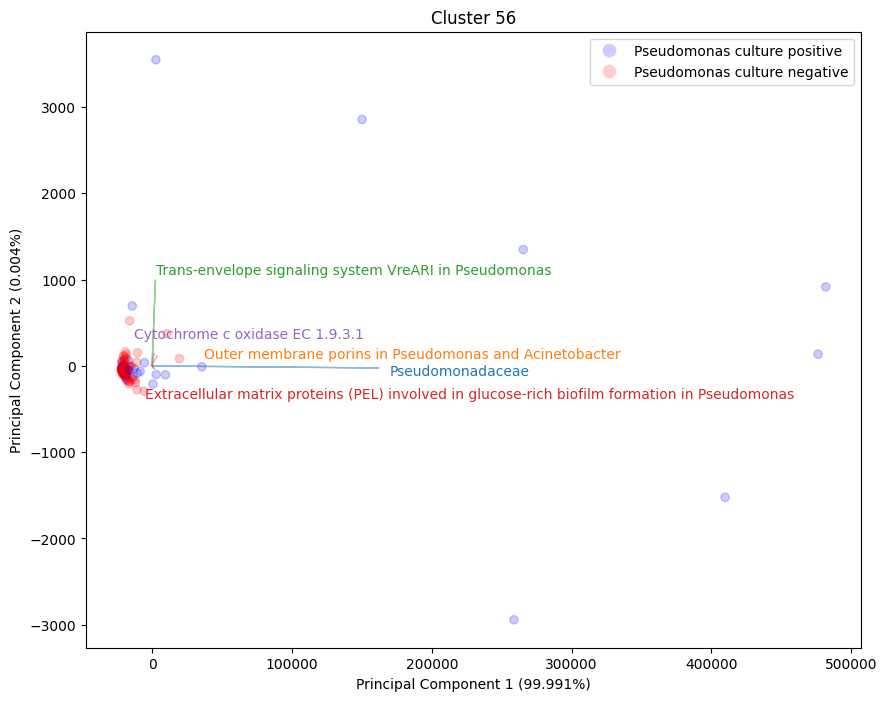

In [15]:
pca = PCA(n_components=2)

intcol = 'Pseudomonas Culture'
df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == interesting_cluster, "Feature"]]
merged_df_clust = df_clust.join(metadata[[intcol]])

pca_result = pca.fit_transform(df_clust)
pca_df = pd.DataFrame(data=pca_result, index=df.index, columns=['PC1', 'PC2'])

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=df_clust.columns, columns=['PC1', 'PC2'])

# Create a DataFrame for top loadings
top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]
top_loadings_df.head()

explained_variance = pca.explained_variance_ratio_ * 100
pc1_variance = explained_variance[0]
pc2_variance = explained_variance[1]

colours = np.where(merged_df_clust['Pseudomonas Culture'] == 1, 'blue', 'red')

# Plot the PCA results
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours)
plt.title(f"Cluster {interesting_cluster}")
plt.xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 5
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
colour_cycle = cycle(mcolors.TABLEAU_COLORS)
found_pseudomonas = False
for i in range(maxloadings):
    c = next(colour_cycle)
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color=c, alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color=c))

adjust_text(texts)


# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture positive', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture negative', 
                        markerfacecolor='red', alpha=0.2, markersize=10)


plt.legend(handles=[blue_patch, red_patch])


# Show the plot
plt.show()

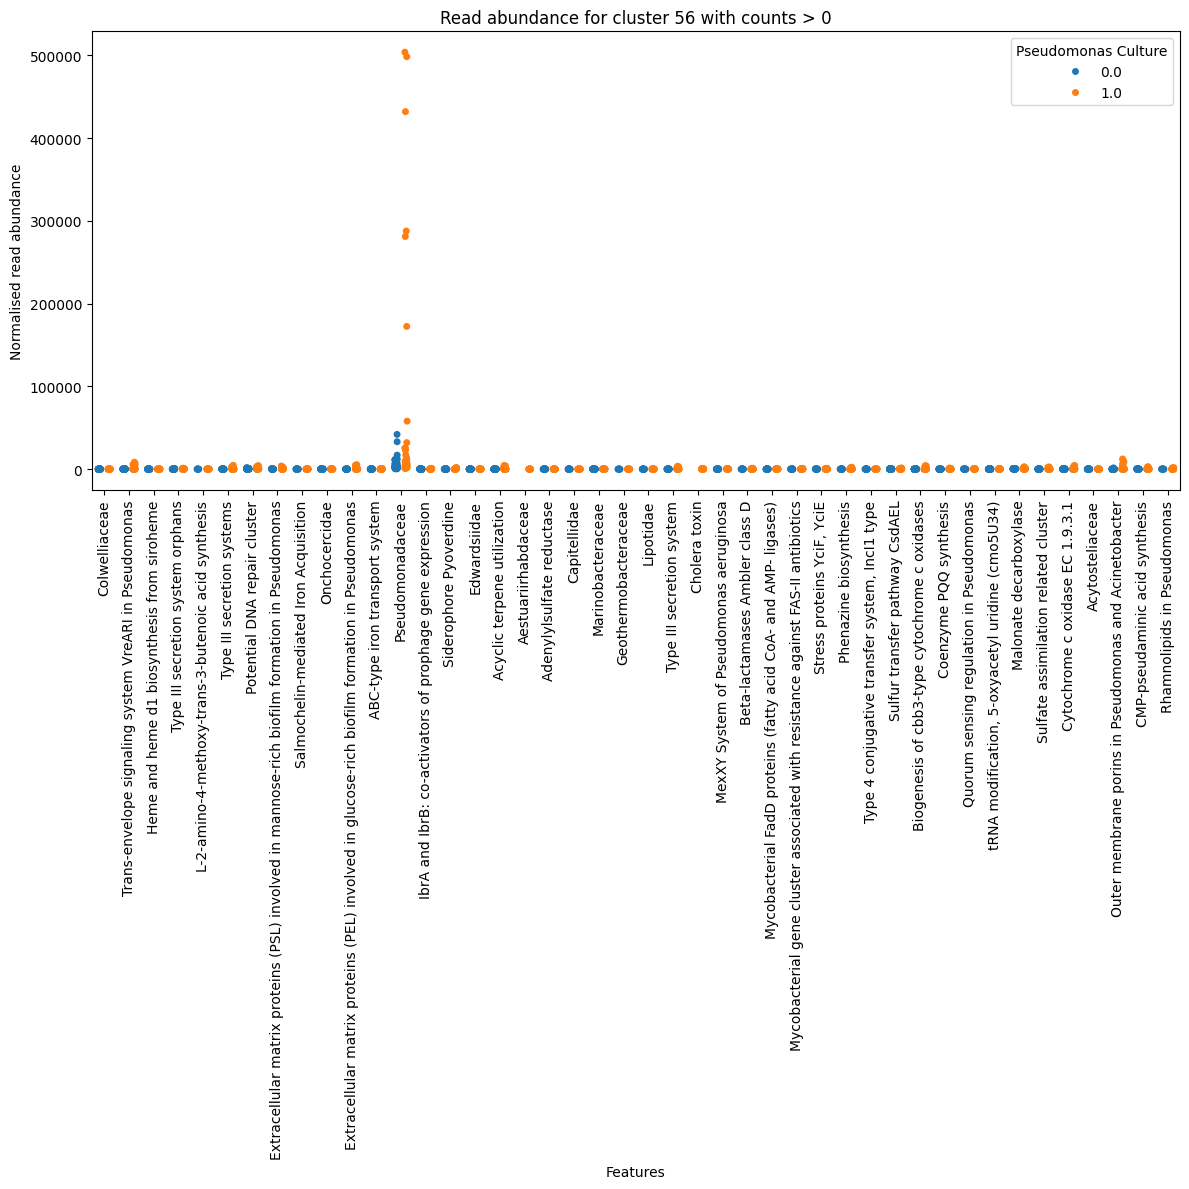

In [16]:
df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == interesting_cluster, "Feature"]]
merged_df_clust = df_clust.join(metadata[[intcol]])
df_clust_m = merged_df_clust.melt(id_vars=intcol, var_name='Features', value_name='Normalised read abundance')
df_clust_m = df_clust_m[df_clust_m['Normalised read abundance'] > 0]
plt.figure(figsize=(12, 12))
sns.stripplot(data=df_clust_m, x='Features', y='Normalised read abundance', hue=intcol, dodge=True, jitter=True)
plt.xticks(rotation=90)
# plt.ylim(0, 10000)
plt.title(f"Read abundance for cluster {interesting_cluster} with counts > 0")
plt.tight_layout()
plt.show()

# GBRF

This code is directly from the GBRF page, but we are using pc_df instead of df, and we're going to predict `Pseudomonas culture`

When we run this multiple times, we get the same answer! Now we only need to run the GBRF once per metadata column

Running the regressor on Pseudomonas Culture has an average mse of 0.14053688580880389


Cluster 184: 0.0363 (3 times)
Cluster 70: 0.0288 (3 times)
Cluster 79: 0.0155 (2 times)
Cluster 56: 0.0146 (2 times)
Cluster 57: 0.0144 (2 times)
Cluster 171: 0.0135 (2 times)
Cluster 181: 0.0133 (2 times)
Cluster 166: 0.0117 (3 times)
Cluster 62: 0.0104 (2 times)
Cluster 33: 0.0101 (2 times)


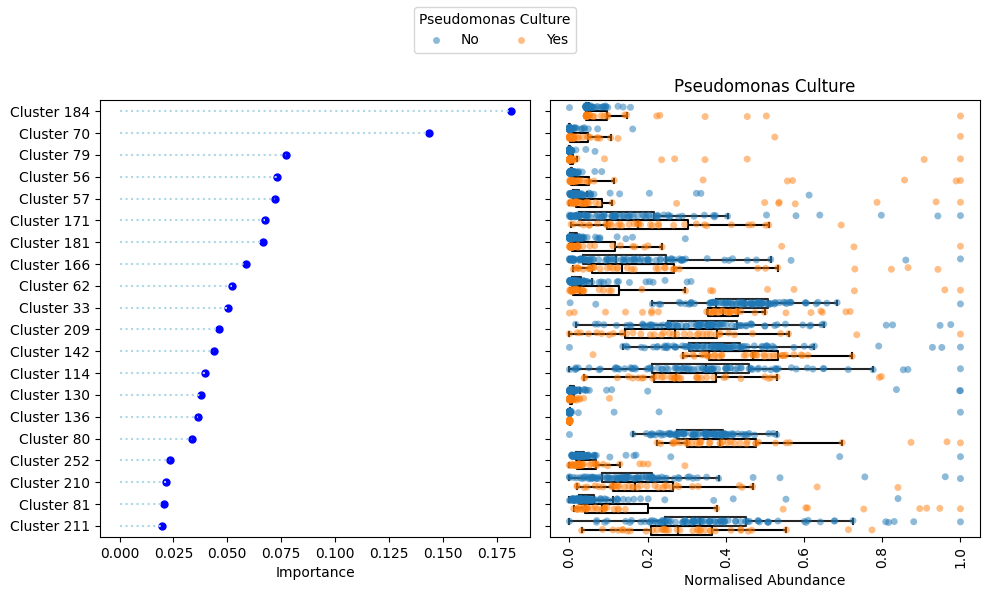

In [17]:
intcol = 'Pseudomonas Culture'

replace_index = re.compile(r'^\d+\s+')
intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

# do we need to encode this column
custom_labels = {0: 'No', 1: 'Yes'}
categorical_data = False
if pd.api.types.is_numeric_dtype(metadata[intcol]):
    # this is an numeric column, so we can just continue
    pass
elif isinstance(metadata[intcol].dtype, pd.CategoricalDtype) and pd.api.types.is_numeric_dtype(metadata[intcol].cat.categories.dtype):
    # this is a categorical column with numeric categories so we can also continue
    categorical_data = True
elif isinstance(metadata[intcol].dtype, pd.CategoricalDtype):
    # this is a categorical column with string categories so we need to encode it
    enc = OrdinalEncoder()
    metadata_encoder = enc.fit(metadata[[intcol]])
    categories = metadata_encoder.categories_[0]
    custom_labels = {code: cat for code, cat in enumerate(categories)}
    merged_df[intcol] = metadata_encoder.transform(metadata[[intcol]])
    categorical_data = True
else:
    # not sure what this is, so we skip it for now
    print(f"Error: {intcol} is not a numeric or categorical column, but carrying on", file=sys.stderr)
    

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

top_features = {}
top_feature_counts = {}
niterations = 3
msetot = 0
n=20
for i in range(niterations):
    if categorical_data:
      mse, feature_importances_sorted = cf_analysis_lib.gb_classifier(X, y)
      met = 'classifier'
    else:
      mse, feature_importances_sorted = cf_analysis_lib.gb_regressor(X, y)
      met = 'regressor'
    
    msetot += mse
    
    for f in feature_importances_sorted.index[:n]:
        top_features[f] = top_features.get(f, 0) + feature_importances_sorted.loc[f, 'importance']
        top_feature_counts[f] = top_feature_counts.get(f, 0) + 1

print(f"Running the {met} on {intcol_title} has an average mse of {msetot/niterations}", file=sys.stderr)

cf_analysis_lib.plot_top_features(merged_df, top_features, top_feature_counts, intcol, intcol_title, custom_labels)

## Aspergillus

Since this is Euks, lets check Aspergillus!

Running the classifier on CS Aspergillus fumigatus has an average mse of 0.15384615384615385


Cluster 149: 0.0226 (3 times)
Cluster 297: 0.0181 (3 times)
Cluster 285: 0.0177 (3 times)
Cluster 54: 0.0153 (3 times)
Cluster 248: 0.0153 (3 times)
Cluster 193: 0.0150 (3 times)
Cluster 237: 0.0134 (3 times)
Cluster 288: 0.0119 (3 times)
Cluster 130: 0.0109 (3 times)
Cluster 298: 0.0101 (3 times)


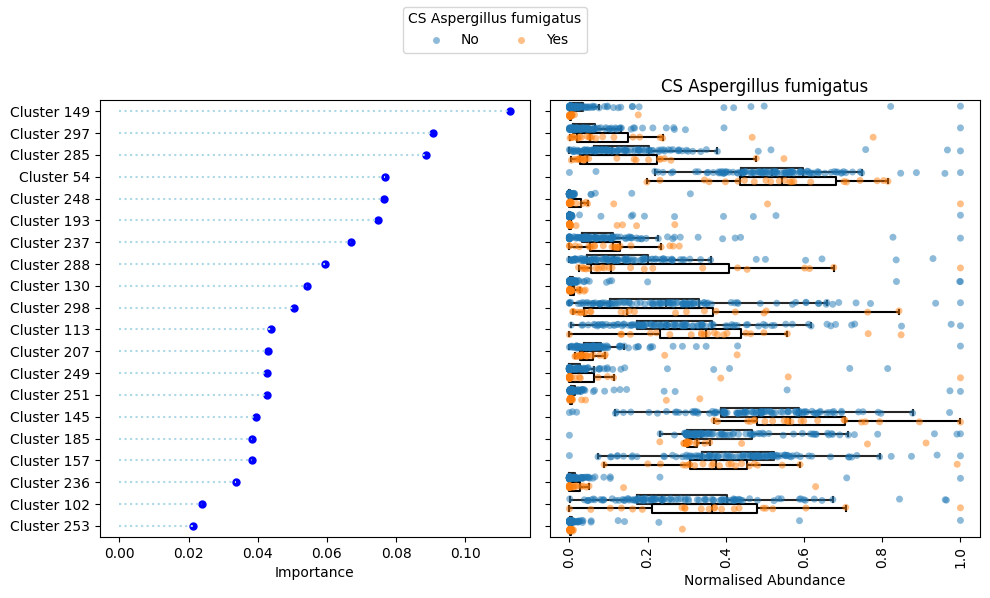

In [18]:
intcol = 'CS_Aspergillus fumigatus'

replace_index = re.compile(r'^\d+\s+')
intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

# do we need to encode this column
custom_labels = {0: 'No', 1: 'Yes'}
categorical_data = False
if pd.api.types.is_numeric_dtype(metadata[intcol]):
    # this is an numeric column, so we can just continue
    pass
elif isinstance(metadata[intcol].dtype, pd.CategoricalDtype) and pd.api.types.is_numeric_dtype(metadata[intcol].cat.categories.dtype):
    # this is a categorical column with numeric categories so we can also continue
    categorical_data = True
elif isinstance(metadata[intcol].dtype, pd.CategoricalDtype):
    # this is a categorical column with string categories so we need to encode it
    enc = OrdinalEncoder()
    metadata_encoder = enc.fit(metadata[[intcol]])
    categories = metadata_encoder.categories_[0]
    custom_labels = {code: cat for code, cat in enumerate(categories)}
    merged_df[intcol] = metadata_encoder.transform(metadata[[intcol]])
    categorical_data = True
else:
    # not sure what this is, so we skip it for now
    print(f"Error: {intcol} is not a numeric or categorical column, but carrying on", file=sys.stderr)
    

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

top_features = {}
top_feature_counts = {}
niterations = 3
msetot = 0
n=20
for i in range(niterations):
    if categorical_data:
      mse, feature_importances_sorted = cf_analysis_lib.gb_classifier(X, y)
      met = 'classifier'
    else:
      mse, feature_importances_sorted = cf_analysis_lib.gb_regressor(X, y)
      met = 'regressor'
    
    msetot += mse
    
    for f in feature_importances_sorted.index[:n]:
        top_features[f] = top_features.get(f, 0) + feature_importances_sorted.loc[f, 'importance']
        top_feature_counts[f] = top_feature_counts.get(f, 0) + 1

print(f"Running the {met} on {intcol_title} has an average mse of {msetot/niterations}", file=sys.stderr)

cf_analysis_lib.plot_top_features(merged_df, top_features, top_feature_counts, intcol, intcol_title, custom_labels)

# Run the GBRF for every metadata sample

This code is taken from the gradient_boosting.py script with some minor changes, but runs the GBRF once per sample.

In [24]:
# ignore adjustText warnings in this block
warnings.filterwarnings("ignore", category=UserWarning, module='adjustText')

replace_index = re.compile(r'^\d+\s+')
replace_nonword = re.compile(r'\W+')

resultsfile = open(os.path.join(outdir, 'gbrf_results.txt'), 'w')
print(f"Predictor\tFeature\tImportance", file=resultsfile)

skip_columns = {'minion', 'MGI', 'pwCF_ID', 'Sample_Type', 'Corr', 'CF gene 1', 'CS_NTM_(Smear negative)', 'CS_Aspergillus niger', 'CS_Aspergillus terreus',
                'CS_Scedosporium apiospermum', 'O_Scedosporium apiospermum', 'O_Trichosporon mycotoxinivorans', '3 Aztreonam_IV',
                'DNA_extraction_ conc', 'SAGC ULN', 'DNA Conc. (ng/ul)',
                'Index I7', 'Index I5', 'Mean_Size_BP', 'Total Clusters Passing Filter (Million)'}

n_estimators=1000

# make the image directories
os.makedirs(os.path.join(outdir, "img", "clusters"), exist_ok=True)

shouldskip = []
doskip = False
for intcol in metadata.columns:
    if intcol == 'XXXXX': # replace this if you want to restart part way through!
        doskip = False
    if doskip:
        continue
    if intcol in skip_columns:
        continue
    print(f"Working on {intcol}", file=sys.stderr)

    # set up our titles and the filename
    intcol_title = replace_index.sub('', intcol)
    intcol_filename = intcol.replace(" ", "_")
    intcol_filename = replace_nonword.sub('', intcol_filename)

    merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

    # do we need to encode this column
    custom_labels = {0: 'No', 1: 'Yes'}
    categorical_data = False
    if pd.api.types.is_numeric_dtype(metadata[intcol]):
        # this is an numeric column, so we can just continue
        categorical_data = False
    elif isinstance(metadata[intcol].dtype, pd.CategoricalDtype) and pd.api.types.is_numeric_dtype(metadata[intcol].cat.categories.dtype):
        # this is a categorical column with numeric categories so we can also continue
        categorical_data = True
    elif isinstance(merged_df[intcol].dtype, pd.CategoricalDtype):
        # this is a categorical column with string categories so we need to encode it
        enc = OrdinalEncoder()
        metadata_encoder = enc.fit(merged_df[[intcol]])
        categories = metadata_encoder.categories_[0]
        custom_labels = {code: cat for code, cat in enumerate(categories)}
        merged_df[intcol] = metadata_encoder.transform(merged_df[[intcol]])
        categorical_data = True
    else:
        # not sure what this is, so we skip it for now
        print(f"Error: {intcol} is not a numeric or categorical column. Skipped", file=sys.stderr)
        continue

    X = merged_df.drop(intcol, axis=1)
    y = merged_df[intcol]


    met = None

    if categorical_data or metadata[intcol].dtype == 'object':
        try:
            mse, feature_importances_sorted = cf_analysis_lib.gb_classifier(X, y, n_estimators)
            met = 'classifier'
        except ValueError as e:
            shouldskip.append(intcol)
            continue
    else:
        try:
            mse, feature_importances_sorted = cf_analysis_lib.gb_regressor(X, y, n_estimators)
            met = 'regressor'
        except ValueError as e:
            shouldskip.append(intcol)
            continue

    print(f"Mean squared error for {intcol} using {met} is {mse}", file=resultsfile)
    
    print(f"Features appearing at least once", file=resultsfile)
    for x in feature_importances_sorted.index[:20]:
        print(f"{intcol}\t{x}\t{feature_importances_sorted.loc[x, 'importance']}", file=resultsfile)
    print(file=resultsfile)
        
    y_features = 10

    topN = list(feature_importances_sorted[:y_features].index) + [intcol]
    fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=2, sharey='row', sharex='col')
    cf_analysis_lib.plot_feature_importance(axes[0], feature_importances_sorted[:y_features][::-1], "")
    cf_analysis_lib.plot_feature_abundance(axes[1], merged_df[topN][::-1], intcol, intcol_title)


    handles, labels = axes[1].get_legend_handles_labels()  # Get one set of handles and labels
    updated_labels = labels
    try:
        updated_labels = [custom_labels[float(label)] for label in labels]
    except Exception as e:
        print(f"Couldn't use float for labels {e}.", file=sys.stderr)

    for ax in axes.flat:
        if ax.get_legend() is not None:  # Check if legend exists
            ax.get_legend().remove()

    plt.xticks(rotation=90)
    fig.legend(handles, updated_labels, loc='upper center', ncol=2, title=intcol_title)
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.savefig(os.path.join(outdir, "img", f"{intcol_filename}_importance_abundance.png"))
    plt.close()


    for interesting_cluster in feature_importances_sorted[:y_features].index:
        int_cluster_num = int(interesting_cluster.replace("Cluster ", ""))
        if cluster_assignments[cluster_assignments["Cluster"] == int_cluster_num].shape[0] < 2:
            continue
        interesting_cluster_filename = interesting_cluster.replace(" ", "_")
        fig, axes = plt.subplots(figsize=(8, 11), nrows=2, ncols=1)
        cf_analysis_lib.plot_pca(axes[0], df, metadata, cluster_assignments, int_cluster_num, intcol)
        cf_analysis_lib.plot_abundance_stripplot(axes[1], df, metadata, cluster_assignments, int_cluster_num, intcol)
        plt.tight_layout()
        plt.savefig(os.path.join(outdir, "img", "clusters", f"{intcol_filename}_{interesting_cluster_filename}.png"))
        plt.close()
    

resultsfile.close()

if shouldskip:
    print(f"THESE MODELS FAILED. We skipped them, and you should!\n{shouldskip}", file=sys.stderr)

Working on Sample date
Error: Sample date is not a numeric or categorical column. Skipped
Working on IP vs OP
Working on Hospital
Working on Room
Error: Room is not a numeric or categorical column. Skipped
Working on Age
Couldn't use float for labels 8.0.
Working on Age groups
Couldn't use float for labels 2.0.
Working on Paediatric vs Adult
Working on Gender
Working on H2_Uncorrected
Couldn't use float for labels 20.0.
Working on CH4_Uncorrected
Couldn't use float for labels 4.0.
Working on CO2
Couldn't use float for labels 2.4.
Working on H2_Corrected
Couldn't use float for labels 25.0.
Working on CH4_Corrected
Couldn't use float for labels 6.0.
Working on CH4/H2 ratio_corrected
Couldn't use float for labels 1.5.
Working on Corr.
Couldn't use float for labels 1.2.
Working on Culture Result (Matched with sequenced sample)
Error: Culture Result (Matched with sequenced sample) is not a numeric or categorical column. Skipped
Working on NTM
Working on Pseudomonas Culture
Working on Cuture

0 [-0.95196474 -0.90228536]
1 [-0.88882053  0.63479515]


Working on P12M_0_Nothing
Working on P12M_1_Staphylococcus aureus
Working on P12M_2_Pseudomonas aeruginosa
Working on P12M_3_Stenotrophomonas maltophilia
Working on P12M_4_Rapid NTM
Working on P12M_5_Slow NTM
Working on P12M_6_Aspergillus
Working on P12M_7_Burkholderia cepacia
Working on P12M_8_Haemophilus influenza
Working on P12M_9_Streptococcus pneumoniae
Working on P12M_10_Achromobacter xylosoxidans
Working on P12M_11_Serratia marcesens
Working on P12M_12_Inquilinus limosus
Working on P12M_13_Scedosporum apiospermum
Working on P12M_14_Moraxella catarrhalis
Working on Next PA Positive Date
Error: Next PA Positive Date is not a numeric or categorical column. Skipped
Working on Positive for PA within next 12 months
Working on Culture for next sample
Error: Culture for next sample is not a numeric or categorical column. Skipped
Working on N12M_Pseudomonas aeruginosa
Working on N12M_Pseudomonas aeruginosa (multi-resistant)
Working on N12M_mucoid
Working on N12M_non_mucoid
Working on N12

0 [-0.37895712  0.69912864]
1 [-0.29382607  0.96107652]


Working on N12M_M gordonae
Working on N12M_M chelonae
Working on O_Penicillium species
Working on O_Enterobacter cloacae
Working on O_Aspergillus Flavus
Working on O_Mycobacterium abscessus
Working on O_Cupriavidus gilardii
Working on O_Mycobacterium intracellular
Working on O_Pseudomonas aeruginosa (multi-resistant)
Working on O_Streptococcus pyogenes
Working on O_Pseudomonas aeruginosa (non-mucoid)
Working on O_Chryseobacterium indologenes
Working on O_Bordetella species
Working on O_Klebsiella oxytoca
Working on O_Mycobacterium mucogenicum
Working on O_Mycobacterium scotochromogen
Working on O_Acinetobacter species
Working on O_Enterobacter species
Working on O_Aspergillus niger
Working on O_Aspergillus terreus
Working on O_Pseudomonas aeruginosa (mucoid)
Working on O_Proteus mirabilis
Working on O_talaromyces purpurogenus
Working on Antibiotics (duration)
Error: Antibiotics (duration) is not a numeric or categorical column. Skipped
Working on Antibiotics_YN
Working on IV
Working on

0 [ 0.27756063 -0.38284015]
1 [-0.5732094   0.05718193]


Working on 2 Amphotericin B (Ambisome)_INH
Working on 4 Amikacin_IV
Working on 2 Amikacin_INH
Working on 2 Amoxicillin & Potassium clavulanate (Aug Duo)_PO
Working on 3 Azithromycin_IV
Working on 2 Azithromycin_PO
Working on 3 Cefopime_IV
Working on 4 Cefoxitin_IV
Working on 3 Ceftazidime_IV
Working on 2 Ceftazidime_INH
Working on 1 Cephalexin_PO
Working on 2 Ciprofloxacin_PO


0 [ 0.19146693 -0.20499779]
1 [-0.38767399 -0.34673242]


Working on 2 Clarithromycin_PO
Working on 2 Clofazimine PO
Working on 4 Colistin_IV
Working on 2 Colistin_IHN
Working on 1 Flucloaxcillin_PO
Working on 3 Imipenem
Working on 1 Itraconazole (Lozenoc)_PO
Working on 3 Ivacaftor (Kalydeco)
Working on 3 Meropenem_IV
Working on 3 Methylpredinosolone_IV
Working on 3 Omalizumab_SC
Working on 3 piperacillin sodium, tazobactam sodium (Tazocin)_IV
Working on 2 prednisolone_PO
Working on 1 Sulfamethoxazole_trimethoprim (Bactrim)_PO
Working on 3 tobramycin_IV
Working on 2 tobramycin_INH
Working on Sum of antibiotics
Couldn't use float for labels 2.0.
Working on Sum of meds
Couldn't use float for labels 2.0.
Working on Sum of antifungals
Couldn't use float for labels 2.0.
Working on Sum of steroid + mabs
Couldn't use float for labels 2.0.


In [25]:
df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == interesting_cluster, "Feature"]]
df_clust

""
1068841_20180306_S
1447437_20171212_S
1128691_20171206_S
1128691_20171218_S
1128691_20180116_S
...
895293_20180502_S
896213_20180427_S
913873_20180417_S
980574_20180403_S


# Random Forest for a Single Column

This repeats the RF for one column, but doesn't save any files.

'CS_Aspergillus fumigatus' has samples from 22 pwCF


Mean squared error for CS_Aspergillus fumigatus using classifier is 0.15384615384615385


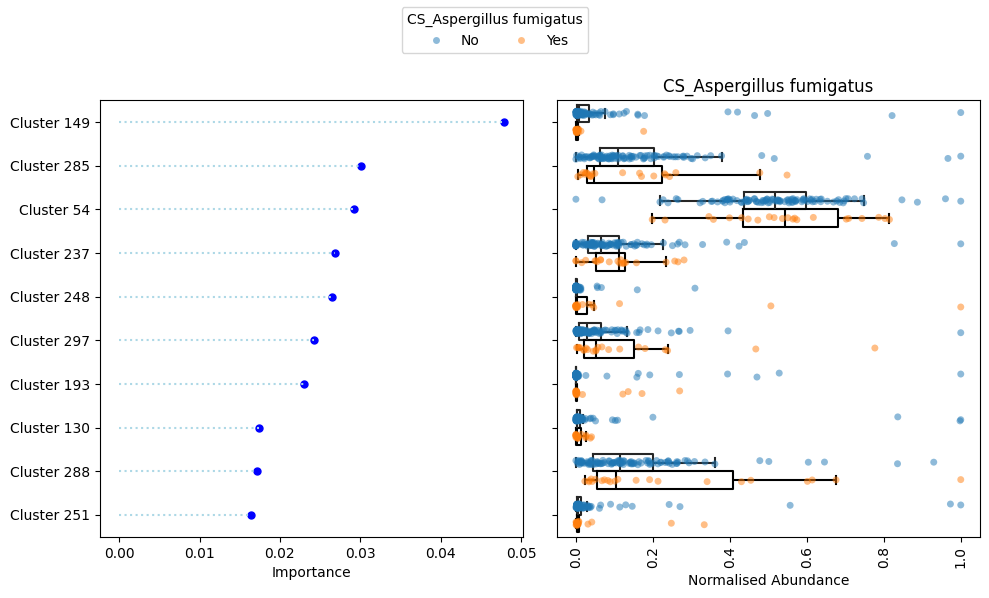

In [26]:
intcol = 'CS_Aspergillus fumigatus'
print(f"'{intcol}' has samples from {metadata.groupby(intcol).size()[1]} pwCF")

# ignore adjustText warnings in this block
warnings.filterwarnings("ignore", category=UserWarning, module='adjustText')

replace_index = re.compile(r'^\d+\s+')
replace_nonword = re.compile(r'\W+')


n_estimators=1000

# set up our titles and the filename
intcol_title = replace_index.sub('', intcol)
intcol_filename = intcol.replace(" ", "_")

merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

# do we need to encode this column
custom_labels = {0: 'No', 1: 'Yes'}
categorical_data = False
if pd.api.types.is_numeric_dtype(metadata[intcol]):
    # this is an numeric column, so we can just continue
    categorical_data = False
elif isinstance(metadata[intcol].dtype, pd.CategoricalDtype) and pd.api.types.is_numeric_dtype(metadata[intcol].cat.categories.dtype):
    # this is a categorical column with numeric categories so we can also continue
    categorical_data = True
elif isinstance(merged_df[intcol].dtype, pd.CategoricalDtype):
    # this is a categorical column with string categories so we need to encode it
    enc = OrdinalEncoder()
    metadata_encoder = enc.fit(merged_df[[intcol]])
    categories = metadata_encoder.categories_[0]
    custom_labels = {code: cat for code, cat in enumerate(categories)}
    merged_df[intcol] = metadata_encoder.transform(merged_df[[intcol]])
    categorical_data = True
else:
    # not sure what this is, so we skip it for now
    print(f"Error: {intcol} is not a numeric or categorical column. Skipped", file=sys.stderr)


X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]


met = None

if categorical_data or metadata[intcol].dtype == 'object':
    mse, feature_importances_sorted = cf_analysis_lib.gb_classifier(X, y, n_estimators)
    met = 'classifier'
else:
    mse, feature_importances_sorted = cf_analysis_lib.gb_regressor(X, y, n_estimators)
    met = 'regressor'


print(f"Mean squared error for {intcol} using {met} is {mse}", file=sys.stderr)

    
y_features = 10

topN = list(feature_importances_sorted[:y_features].index) + [intcol]
fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=2, sharey='row', sharex='col')
cf_analysis_lib.plot_feature_importance(axes[0], feature_importances_sorted[:y_features][::-1], "")
cf_analysis_lib.plot_feature_abundance(axes[1], merged_df[topN][::-1], intcol, intcol_title)


handles, labels = axes[1].get_legend_handles_labels()  # Get one set of handles and labels
updated_labels = labels
try:
    updated_labels = [custom_labels[float(label)] for label in labels]
except Exception as e:
    print(f"Couldn't use float for labels {e}.", file=sys.stderr)

for ax in axes.flat:
    if ax.get_legend() is not None:  # Check if legend exists
        ax.get_legend().remove()

plt.xticks(rotation=90)
fig.legend(handles, updated_labels, loc='upper center', ncol=2, title=intcol_title)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


# Print some information about an interesting cluster or column

# Manually make an image. 

Note that this recreates the images we make automatically, but allows you to tweak things. It saves them to a new location!

'CS_Aspergillus fumigatus' has samples from 22 pwCF


Wrote the new image to cluster_gbrfs_eukaryotes/img/clusters_manual/CS_Aspergillus_fumigatus_Cluster_149.png


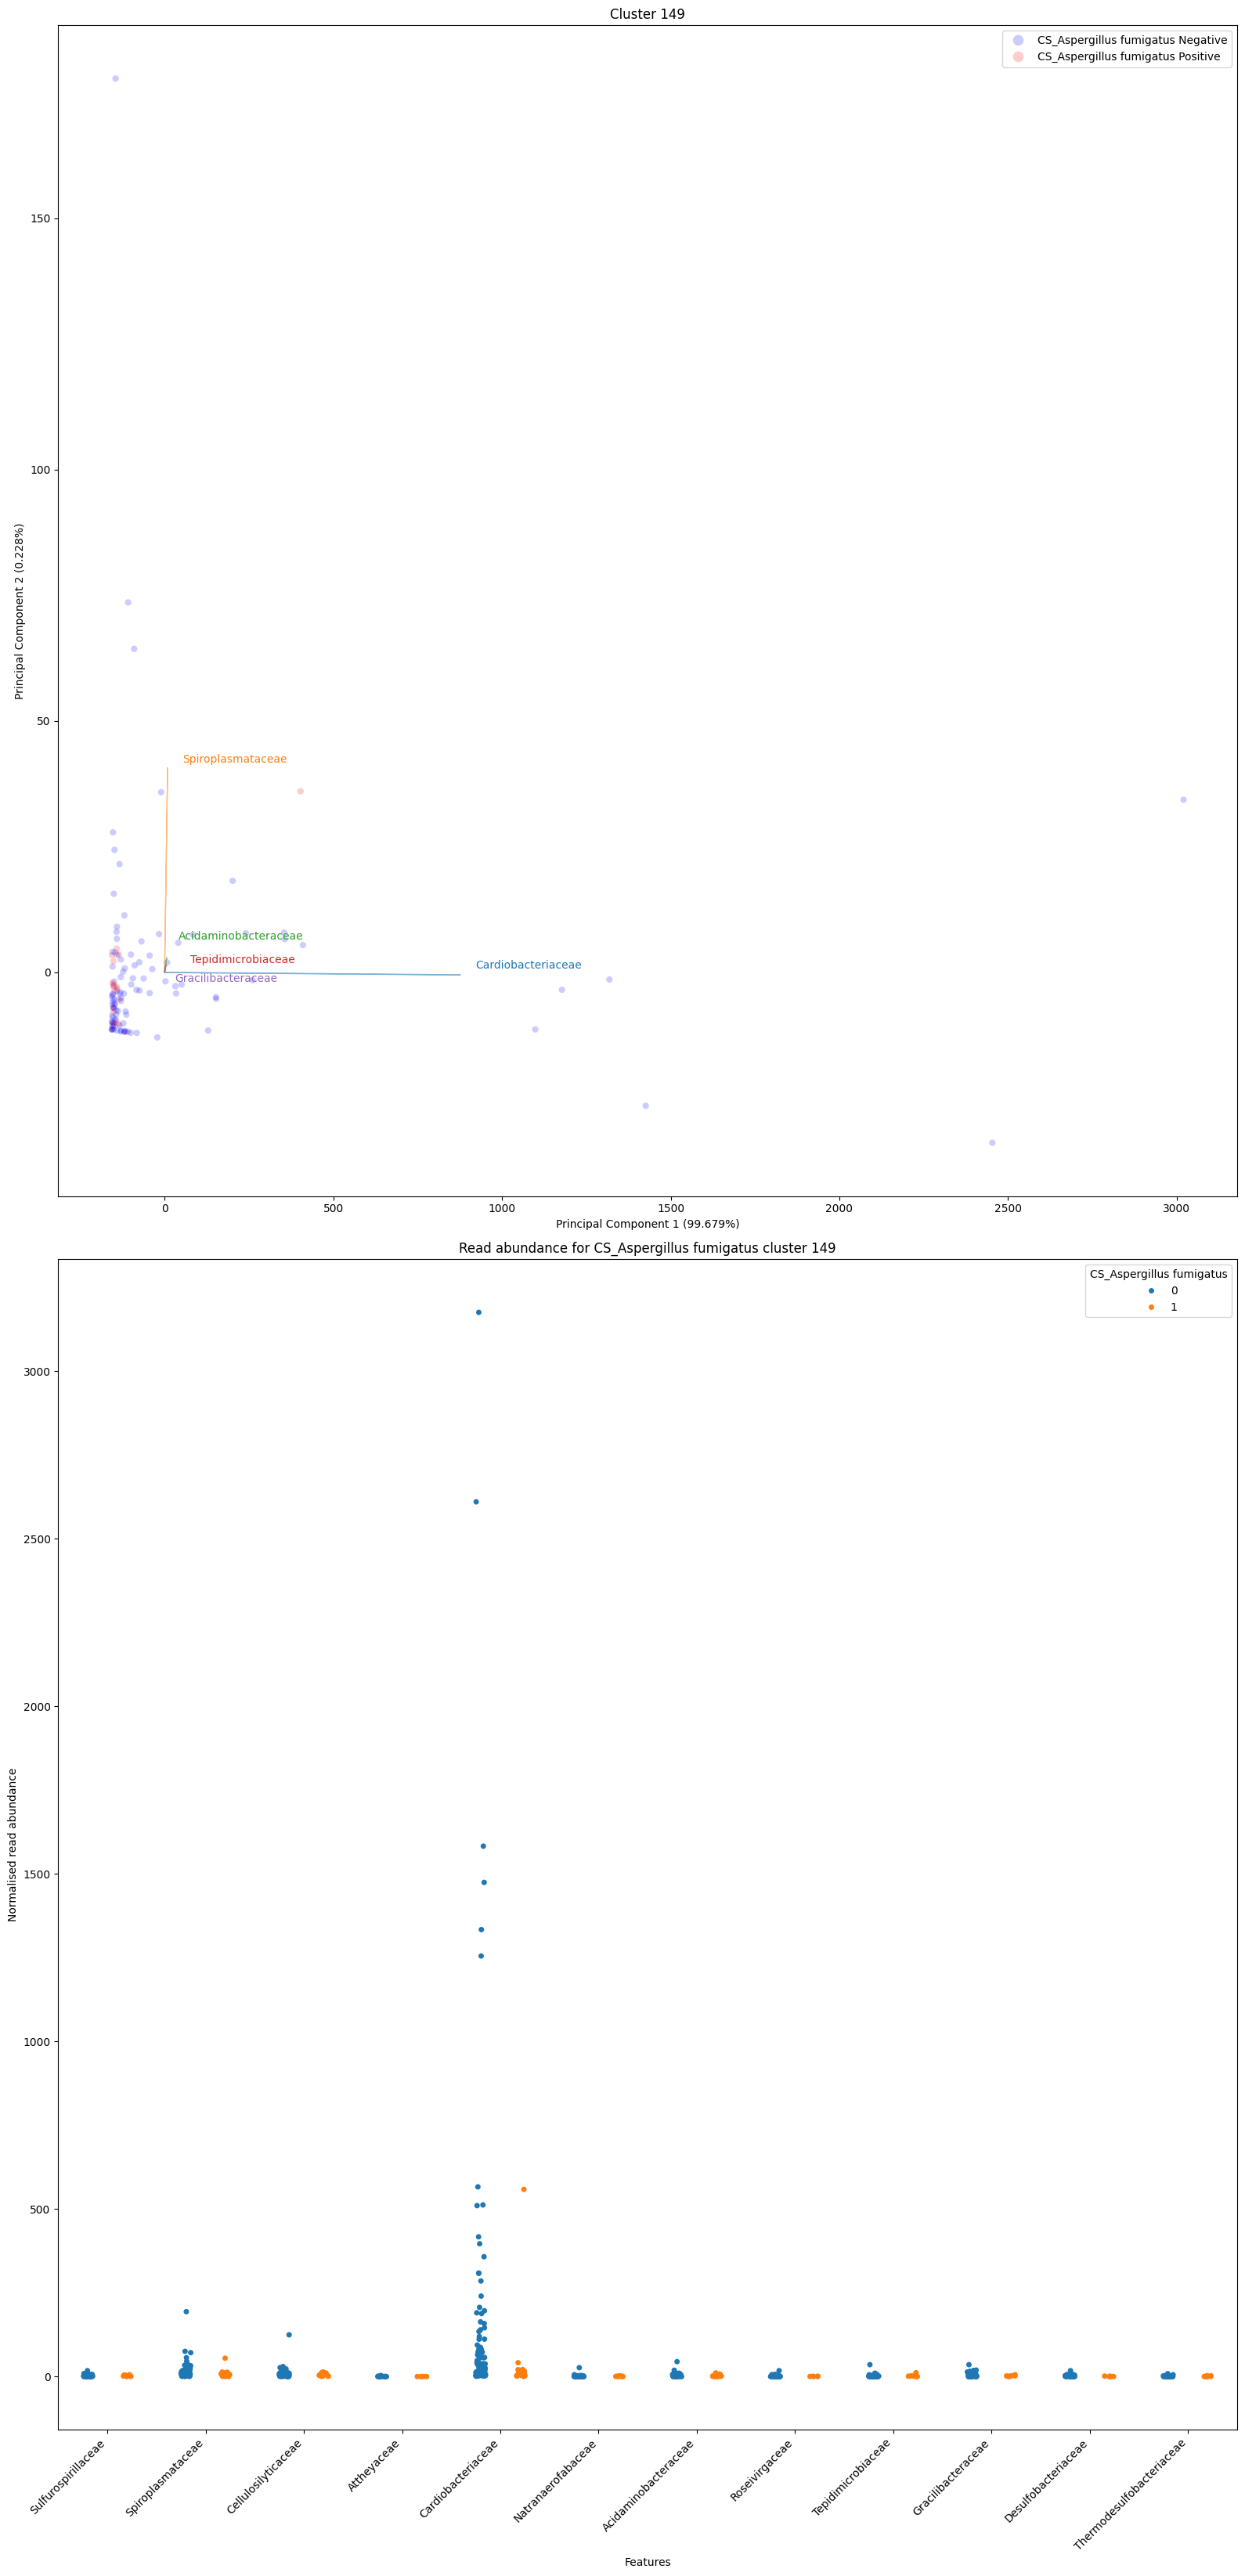

In [27]:
intcol = 'CS_Aspergillus fumigatus'
interesting_cluster = 149
print(f"'{intcol}' has samples from {metadata.groupby(intcol).size()[1]} pwCF")

if isinstance(interesting_cluster, int):
    interesting_cluster_filename = f"Cluster_{interesting_cluster}"
elif 'Cluster' in interesting_cluster:
    interesting_cluster_filename = interesting_cluster.replace(" ", "_")
else:
    interesting_cluster_filename = f"Cluster_{interesting_cluster}"
intcol_filename = intcol.replace(" ", "_")
intcol_filename = replace_nonword.sub('', intcol_filename)


# make a new dir so we don't overwrite!
os.makedirs(os.path.join(outdir, "img", "clusters_manual"), exist_ok=True)

pca = PCA(n_components=2)
int_cluster_num = interesting_cluster

df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == int_cluster_num, "Feature"]]
merged_df_clust = df_clust.join(metadata[[intcol]])

if intcol == 'CFLD':
    mask = merged_df_clust[intcol].notna() & (merged_df_clust[intcol] != 'Unknown')
    merged_df_clust = merged_df_clust[mask]
    merged_df_clust[intcol] = merged_df_clust[intcol].cat.remove_unused_categories()
    df_clust = merged_df_clust.drop(intcol, axis=1)

pca_result = pca.fit_transform(df_clust)
pca_df = pd.DataFrame(data=pca_result, index=df_clust.index, columns=['PC1', 'PC2'])

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=df_clust.columns, columns=['PC1', 'PC2'])

# Create a DataFrame for top loadings
top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]
top_loadings_df.head()

explained_variance = pca.explained_variance_ratio_ * 100
pc1_variance = explained_variance[0]
pc2_variance = explained_variance[1]

# don't forget to change the legend
intcol_neg = 0

colours = np.where(merged_df_clust[intcol] == intcol_neg, 'blue', 'red')

# Plot the PCA results
fig, axes = plt.subplots(figsize=(16, 33), nrows=2, ncols=1)
ax = axes[0]
sns.scatterplot(data=pca_df, x='PC1', y='PC2', alpha=0.2, c=colours, ax=ax)
ax.set_title(f"Cluster {interesting_cluster}")
ax.set_xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
ax.set_ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 5
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
colour_cycle = cycle(mcolors.TABLEAU_COLORS)


for i in range(maxloadings):
    c = next(colour_cycle)
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    ax.arrow(0, 0, xpos, ypos, 
              color=c, alpha=0.5, width=0.05)
    loading_text = top_loadings_df.index[i]
    if len(loading_text) > 30:
        loading_text = loading_text[:30] + "..."
    texts.append(ax.text(xpos, ypos, loading_text, color=c))

adjust_text(texts, ax=ax)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label=f'{intcol} Negative', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label=f'{intcol} Positive', 
                        markerfacecolor='red', alpha=0.2, markersize=10)
ax.legend(handles=[blue_patch, red_patch])

## Read abundance
ax = axes[1]

df_clust_m = merged_df_clust.melt(id_vars=intcol, var_name='Features', value_name='Normalised read abundance')
df_clust_m = df_clust_m[df_clust_m['Normalised read abundance'] > 0]

cl = {'IP': 'red', 'OP': 'blue'}
sns.stripplot(data=df_clust_m, x='Features', y='Normalised read abundance', hue=intcol, dodge=True, jitter=True, ax=ax)

ax.tick_params(axis='x', rotation=45)
for label in ax.get_xticklabels():
    label.set_horizontalalignment('right')
ax.set_title(f"Read abundance for {intcol} cluster {interesting_cluster}")


plt.tight_layout()
plt.savefig(os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}.png"))
print(f'Wrote the new image to {os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}.png")}', file=sys.stderr)
# Show the plot
plt.show()

# Plot some non-categorical data!

Some of our data is continuous. Eeek

### Plot using the PCA data

TypeError: Categorical is not ordered for operation min
you can use .as_ordered() to change the Categorical to an ordered one


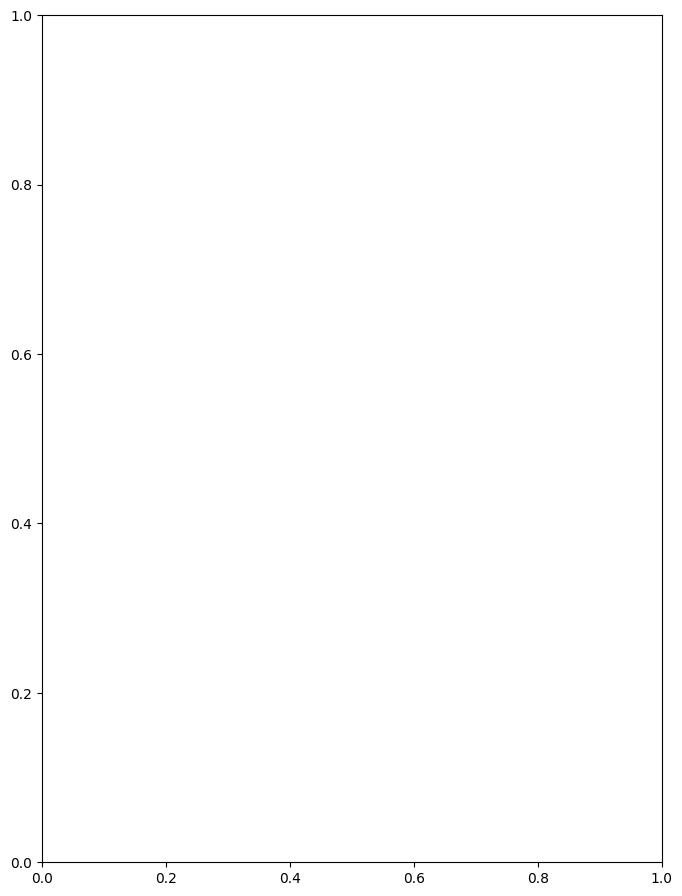

In [28]:
meta_pca = metadata[[intcol]].join(pca_df[['PC1']])
plt.subplots(figsize=(8, 11))
ax = sns.regplot(data=meta_pca, x=intcol, y='PC1',
    scatter=True,         # Plot the scatter points
    fit_reg=True,         # Fit and plot the regression line
    ci=95,                # Shaded 95% confidence interval
    scatter_kws={'color': 'blue', 'alpha': 0.2},  # Customize scatter points
    line_kws={'color': 'red'}  # Customize regression line
)

ax.set_title(f"Read abundance for {intcol} cluster {interesting_cluster}")
plt.tight_layout()

plt.savefig(os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}_regplot.png"))
print(f'Wrote the new image to {os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}_regplot.png")}', file=sys.stderr)
# Show the plot
plt.show()
